In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon

from CST import Element
from nodes import Node
from solve import Solve
#from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa
#from fem import Material, Membrane
#from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace


In [2]:
output_file="prueba_2.msh"

Now is necessary to group the nodes in differnt groups. In this case, there are 3 groups: Heads, handle_big and handle_thin

In [3]:
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}
Materials = {}
# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "quad":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")

        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id+1, x, y))


# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = ["f", "f"]
            if nombre in ["BC_R1"]:
                print(f"Grupo {nombre} - Nodo {node_id+1} - Coordenadas ({x}, {y})")
                restrain = ["r", "r"]

            grupos[nombre].append(Node(node_id+1, x, y, restrain=restrain))

# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.id] = n
    grupos[nombre] = list(nodos_unicos.values())
    print(f"Grupo {nombre} - Cantidad de nodos: {len(grupos[nombre])}")




Block 0 - Tipo: line, Cantidad: 4, Physical tags: {np.int64(1)}
Block 1 - Tipo: line, Cantidad: 1, Physical tags: {np.int64(1)}
Block 2 - Tipo: line, Cantidad: 3, Physical tags: {np.int64(1)}
Block 3 - Tipo: line, Cantidad: 4, Physical tags: {np.int64(1)}
Block 4 - Tipo: line, Cantidad: 4, Physical tags: {np.int64(1)}
Block 5 - Tipo: quad, Cantidad: 16, Physical tags: {np.int64(107)}
Grupo BC_R1 - Nodo 1 - Coordenadas (0.0, 1.0)
Grupo BC_R1 - Nodo 6 - Coordenadas (0.0, 0.75)
Grupo BC_R1 - Nodo 6 - Coordenadas (0.0, 0.75)
Grupo BC_R1 - Nodo 7 - Coordenadas (0.0, 0.5)
Grupo BC_R1 - Nodo 7 - Coordenadas (0.0, 0.5)
Grupo BC_R1 - Nodo 8 - Coordenadas (0.0, 0.25)
Grupo BC_R1 - Nodo 8 - Coordenadas (0.0, 0.25)
Grupo BC_R1 - Nodo 2 - Coordenadas (0.0, 0.0)
Grupo BC_R1 - Nodo 3 - Coordenadas (0.293, 0.9999999999999811)
Grupo BC_R1 - Nodo 1 - Coordenadas (0.0, 1.0)
Grupo BC_R1 - Nodo 3 - Coordenadas (0.293, 0.9999999999999811)
Grupo BC_R1 - Nodo 9 - Coordenadas (0.3877200395243982, 0.6465000000

In [4]:
nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.id] = node

In [5]:
triangles = mesh.cells_dict['quad']
tags = mesh.cell_data_dict["gmsh:physical"]["quad"]
elements = []
nodes = set()

for i in range(len(tags)):
    tag = tags[i]
    group_name = tag_to_name[tag]

    node_ids = triangles[i]
    nodo_a = nodes_dict[node_ids[0]+1]
    nodo_b = nodes_dict[node_ids[1]+1]
    nodo_c = nodes_dict[node_ids[2]+1]
    nodo_d = nodes_dict[node_ids[3]+1]



    for nodo in [nodo_a, nodo_b, nodo_c,nodo_d]:
        nodes.add(nodo)


    elem = Element(i+1, [nodo_a, nodo_b, nodo_c, nodo_d],4)
    elements.append(elem)

nodes = list(nodes)

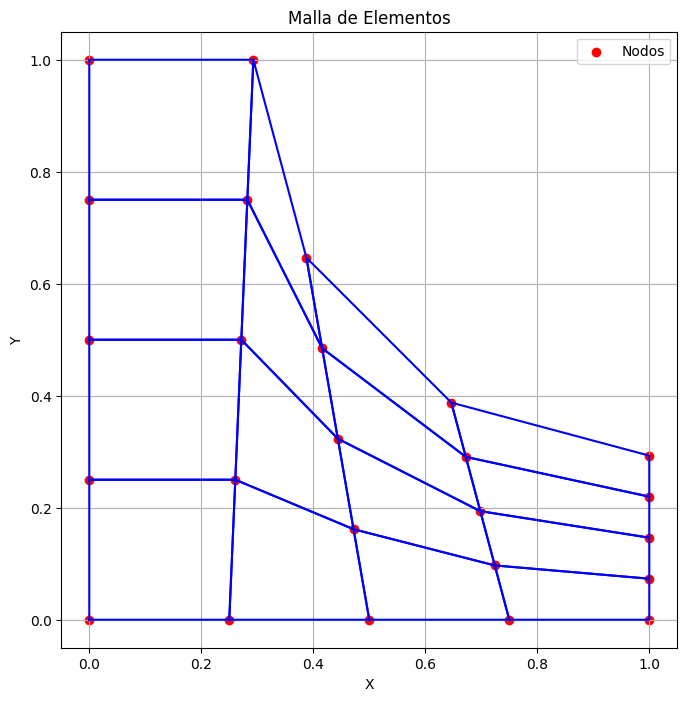

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar la malla
def plot_mesh(nodes_dict, elements):
    # Crear la figura para graficar
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Extraer las coordenadas de los nodos
    x_coords = [node.coordenadas[0] for node in nodes_dict.values()]
    y_coords = [node.coordenadas[1] for node in nodes_dict.values()]
    
    # Graficar los nodos como puntos
    ax.scatter(x_coords, y_coords, c='r', marker='o', label="Nodos")
    


# Asegurándote de que elem.node_ids sean índices y no objetos Node
    for elem in elements:
        node_ids = elem.node_ids  # IDs de los nodos en el elemento
        
        element_coords = []  # Usamos una lista normal para almacenar las coordenadas

        for i in node_ids:
            a = i.x
            b= i.y  # Acceder a las coordenadas del nodo
            
            element_coords.append((a,b))  # Usamos append para agregar coordenadas a la lista

        # Si quieres convertirlo en un array de numpy después de agregar las coordenadas:
        element_coords = np.array(element_coords)
        # Asegurarse de que el primer nodo se conecte al último para cerrar el elemento
        element_coords = np.vstack([element_coords, element_coords[0]])  # Cerrar el loop
        ax.plot(element_coords[:, 0], element_coords[:, 1], 'b-')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Malla de Elementos')
    ax.set_aspect('equal', 'box')  # Aseguramos que la escala sea igual en ambos ejes
    ax.legend()
    
    plt.grid(True)
    plt.show()


# Llamada para graficar la malla
plot_mesh(nodes_dict, elements)



In [7]:
alpha=3
for node in nodes:
        node.solve_u(alpha)


    #Resuelvo la estructura
Estructure = Solve(nodes, elements, alpha)
Estructure.solve_matrix()

    #errores = error(nodes)
solucion_analitica = Estructure.semi_norm_H1_0(alpha)
print(f"Solución analítica: {solucion_analitica}")
print("ahora voy a resolver la estructura")
solucion_fem = Estructure.femm_solution()
print(f"Solución FEM: {solucion_fem}")

Solución analítica: 5.600000000000001
ahora voy a resolver la estructura
Solución FEM: 1.7026279086827694
